In [1]:
import math
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torchvision import datasets, transforms

In [2]:
import torchvision.transforms as transforms
from torch.autograd import Variable
from ta import *
from pandas import DataFrame
from pandas import concat
import math
from numpy import reshape
from sklearn.preprocessing import MinMaxScaler
from numpy import array

In [3]:
"""Function for transforming data in lags"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [6]:
'''Loading Data and TA Features'''
train_data = pd.read_csv("../4_Data/S&P500_train.csv") #Data from 1st Jan 2009 to 31 dec 2017
test_data = pd.read_csv("../4_Data/S&P500_test.csv") #Data from 1st Jan 2018 to 31 Dec 2018

#Adding Returns Variable into the Dataframe
train_data['returns'] = train_data['Close Price'].pct_change()
test_data['returns'] = test_data['Close Price'].pct_change()

#Adding TA Features using TA Library
train_val = add_all_ta_features(train_data, "Open Price", "High Price", "Low Price", "Close Price", "Volume", fillna=True)
test_val = add_all_ta_features(test_data, "Open Price", "High Price", "Low Price", "Close Price", "Volume", fillna=True)

#Remove Date from the train and test datasets
trainset_val = train_val.drop(['Date'], axis=1)
testset_val = test_val.drop(['Date'], axis=1)

#Remove all NaN from returns column
trainset_val = trainset_val.dropna()
testset_val = testset_val.dropna()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ta/trend.py:170: RuntimeWarning: divide by zero encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ta/trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ta/trend.py:174: RuntimeWarning: divide by zero encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ta/trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ta/trend.py:176: RuntimeWarning: invalid value encountered in subtract
  dx = 100 * np.abs((dip - din) / (dip + din))


In [8]:
'''Importing Plotting functions'''
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
sns.set()

In [9]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [10]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

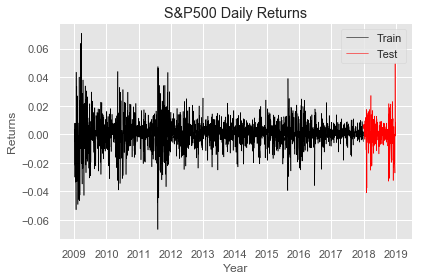

In [11]:
"""Plot of Train and Test Daily returns"""
plt.style.use('ggplot')

#Setting Plot Title
plt.title('S&P500 Daily Returns')

#Setting Labels for X and Y axis
plt.xlabel('Year')
plt.ylabel('Returns')

#Two different plots; train and test
plt.plot(train_data['Date'], train_data['returns'], color="black", label='Train', linewidth=0.55)
plt.plot(test_data['Date'], test_data['returns'], color="red", label='Test', linewidth=0.55)

#Setting legend
plt.legend()
plt.tight_layout()

#Code below is for saving the image
#plt.savefig('daily_returns.png')

In [12]:
"""ADF test for stationality"""
from statsmodels.tsa.stattools import adfuller
"""Class to test for stationality"""
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)      
sTest = StationarityTests()    
sTest.ADF_Stationarity_Test(train_data['returns'].dropna(), printResults = True) 
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.059592e+01
P-Value                 6.350548e-19
# Lags Used             2.400000e+01
# Observations Used     2.238000e+03
Critical Value (1%)    -3.433275e+00
Critical Value (5%)    -2.862832e+00
Critical Value (10%)   -2.567458e+00
dtype: float64
Is the time series stationary? True


In [13]:
#Lasso Regression as Feature Selection
from sklearn.linear_model import LassoCV

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(trainset_val[trainset_val.columns.difference(['returns'])],
                                                            trainset_val['returns'] 
                                                            )

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [14]:
#Printing out Coefficients that Lasso Model Chose
coef = pd.Series(model_lasso.coef_, index = trainset_val[trainset_val.columns.difference(['returns'])].columns)
coef = coef.sort_values()
coef.tail(50)

trend_trix                -0.000000e+00
volatility_bbm             0.000000e+00
volatility_dcl             0.000000e+00
trend_vortex_diff         -0.000000e+00
trend_vortex_ind_neg       0.000000e+00
trend_vortex_ind_pos      -0.000000e+00
volatility_atr             0.000000e+00
volatility_bbh             0.000000e+00
volatility_bbhi            0.000000e+00
trend_visual_ichimoku_a    0.000000e+00
volatility_dcli           -0.000000e+00
trend_cci                  0.000000e+00
volatility_kch             0.000000e+00
momentum_ao                0.000000e+00
momentum_mfi               0.000000e+00
volume_em                  0.000000e+00
momentum_tsi              -0.000000e+00
momentum_uo                0.000000e+00
volume_cmf                 0.000000e+00
volatility_kcc             0.000000e+00
volatility_kcl             0.000000e+00
volatility_kcli            0.000000e+00
trend_adx_neg             -0.000000e+00
trend_adx_pos             -0.000000e+00
trend_aroon_down          -0.000000e+00


In [15]:
#Selecting the variables that Lasso chooses
train_val = trainset_val[
                        ['trend_adx_neg',
                         'trend_adx_pos',
                         'trend_aroon_down',
                         'volatility_kchi',
                         'trend_aroon_up',
                         'volatility_bbl',
                         'trend_adx',
                         'volatility_bbli',
                         'volume_obv',
                         'volume_fi',
                         'Volume',
                         'volume_vpt',
                         'volume_nvi',
                         'trend_visual_ichimoku_b',
                         'trend_ema_slow',
                         'trend_ichimoku_a',
                         'volatility_dch',
                         'trend_dpo',
                         'trend_ichimoku_b',
                         'trend_aroon_ind',
                         'momentum_rsi',
                         'Close Price',
                         'trend_ema_fast',
                         'momentum_stoch',
                         'others_cr',
                         'momentum_wr',
                         'others_dr',
                         'others_dlr'
                        ]
                        ]
test_val = testset_val[
                        ['trend_adx_neg',
                         'trend_adx_pos',
                         'trend_aroon_down',
                         'volatility_kchi',
                         'trend_aroon_up',
                         'volatility_bbl',
                         'trend_adx',
                         'volatility_bbli',
                         'volume_obv',
                         'volume_fi',
                         'Volume',
                         'volume_vpt',
                         'volume_nvi',
                         'trend_visual_ichimoku_b',
                         'trend_ema_slow',
                         'trend_ichimoku_a',
                         'volatility_dch',
                         'trend_dpo',
                         'trend_ichimoku_b',
                         'trend_aroon_ind',
                         'momentum_rsi',
                         'Close Price',
                         'trend_ema_fast',
                         'momentum_stoch',
                         'others_cr',
                         'momentum_wr',
                         'others_dr',
                         'others_dlr'
                        ]
                        ]
data_headers = train_val

In [17]:
#Scaling and reshaping data
train_y_values = trainset_val['returns']
test_y_values = testset_val['returns']

scaler = MinMaxScaler()

TIME_STEP = 29  # rnn time step / image height  

#Fitting Scaler to the data, generating new dataframe from series_to_supervised function
#Lastly, reshaping the data for fitting into the neural network
train_val = scaler.fit_transform(train_val)
train_x = series_to_supervised(train_val, n_in=TIME_STEP-1, n_out=-1)
train_x = train_x.values
train_x = train_x[:, : ]
train_x = reshape(train_x, (train_x.shape[0], 1, TIME_STEP-1, 28))
train_x = torch.from_numpy(train_x)

train_y = array(train_y_values)
train_y = train_y.reshape(train_y.shape[0], 1)
train_y = scaler.fit_transform(train_y)
train_y = series_to_supervised(train_y, n_in=TIME_STEP-2, n_out=1)
train_y = train_y.iloc[1:]
train_y = train_y.values
train_y = train_y[:, : ]
train_y = reshape(train_y, (train_y.shape[0], 1, TIME_STEP-1, 1))
train_y = torch.from_numpy(train_y)


test_val = scaler.fit_transform(test_val)
test_x = series_to_supervised(test_val, n_in=TIME_STEP-1, n_out=-1)
test_x = test_x.values
test_x = test_x[:, : ]
test_x = reshape(test_x, (test_x.shape[0], 1, TIME_STEP-1, 28))
test_x = torch.from_numpy(test_x)

test_y = array(test_y_values)
test_arr = test_y
test_y = test_y.reshape(test_y.shape[0], 1)
test_y = scaler.fit_transform(test_y)
test_y = series_to_supervised(test_y, n_in=TIME_STEP-2, n_out=1)
test_y = test_y.iloc[1:]
test_y = test_y.values
test_y = test_y[:, : ]
test_y = reshape(test_y, (test_y.shape[0], 1, TIME_STEP-1, 1))
test_y = torch.from_numpy(test_y)

train_x = train_x.double()
train_y = train_y.double()
test_x = test_x.double()
test_y = test_y.double()

In [18]:
"""Data Preparation"""
#Loading data into DataLoader object
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=223, shuffle=False)

In [19]:
"""Shape of train and test set"""
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

torch.Size([2235, 1, 28, 28]) torch.Size([2235, 1, 28, 1])
torch.Size([223, 1, 28, 28]) torch.Size([223, 1, 28, 1])


In [20]:
"""Kurtosis for heavy tails"""
from scipy.stats import kurtosis
print( 
    "Kurtosis: ", kurtosis(train_data['returns'].dropna()) 
)

Kurtosis:  5.2468955580170675


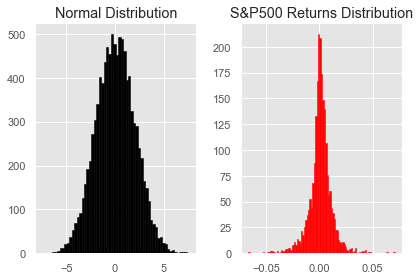

In [21]:
#Histogram of Normal VS Returns - To show Heavy Tails
plt.style.use('ggplot')
x_random = np.random.normal(0, 2, 10000)
x = np.linspace( -5, 5, 10000 )

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(x_random, bins='auto',color = 'black', edgecolor = 'black')
ax1.set_title('Normal Distribution')
ax2.hist(train_data['returns'].dropna(), bins='auto', color = 'red', edgecolor = 'red')
ax2.set_title('S&P500 Returns Distribution')
plt.tight_layout()

#Code below is for saving the image
#plt.savefig('histogram.png')

In [25]:
#SRNN Model
class SRNN(nn.Module):
	def __init__(self, x_dim, h_dim, z_dim, n_layers, bias=False):
		super(SRNN, self).__init__()
		self.x_dim = x_dim
		self.h_dim = h_dim
		self.z_dim = z_dim
		self.n_layers = n_layers


		#encoder  x/u to z, input to latent variable, inference model
		self.enc = nn.Sequential(
			nn.Linear(h_dim, h_dim),
			nn.ReLU(),
			nn.Linear(h_dim, h_dim),
			nn.ReLU())
		self.enc_mean = nn.Linear(h_dim, z_dim)
		self.enc_std = nn.Sequential(
			nn.Linear(h_dim, z_dim),
			nn.Softplus())

		#prior transition of zt-1 to zt
		self.prior = nn.Sequential(
			nn.Linear(h_dim, h_dim),
			nn.ReLU())
		self.prior_mean = nn.Linear(h_dim, z_dim)
		self.prior_std = nn.Sequential(
			nn.Linear(h_dim, z_dim),
			nn.Softplus())

		#decoder from latent variable to output, from z to y
		self.dec = nn.Sequential(
			nn.Linear(h_dim + h_dim, h_dim),
			nn.ReLU(),
			nn.Linear(h_dim, h_dim),
			nn.ReLU())
		self.dec_std = nn.Sequential(
			nn.Linear(h_dim, x_dim),
			nn.Softplus())
		self.dec_mean = nn.Sequential(
			nn.Linear(h_dim, x_dim),
			nn.Sigmoid())
   
		self.rnn = nn.GRU(h_dim + 1, h_dim, n_layers, bias)      
		self.hidden_state_rnn = nn.GRU(h_dim, h_dim, n_layers, bias)          
        

	def forward(self, x, y):
        #generative and inference model
		all_enc_mean, all_enc_std = [], [] #inference
		all_dec_mean, all_dec_std = [], [] 
		kld_loss = 0 #KL in ELBO
		nll_loss = 0 #-loglikihood in ELBO
            
		z_t_sampled = []
		z_t = torch.zeros(self.n_layers, x.size(1), self.h_dim)[-1] 
           
        # computing hidden state in list and x_t & y_t in list outside the loop
		h = torch.zeros(self.n_layers, x.size(1), self.h_dim)   
		h_list = []
		x_t_list = []  
		y_t_list = []
              
		for t in range(x.size(0)):
			x_t = x[t]  
			y_t = y[t]                   
			_, h = self.hidden_state_rnn(torch.cat([x_t], 1).unsqueeze(0), h)      
			y_t_list.append(y_t)             
			x_t_list.append(x_t)            
			h_list.append(h[-1])        
               
        #reversing hidden state list
		reversed_h = h_list
		reversed_h.reverse()
        
        #reversing y_t list
		reversed_y_t = y_t_list
		reversed_y_t.reverse()          
        
        #concat reverse h with reverse x_t
		concat_h_t_y_t_list = []         
 
		for t in range(x.size(0)): #x.size(0) == y.size(0) == 28           
			concat_h_t_y_t = torch.cat([reversed_y_t[t], reversed_h[t]], 1).unsqueeze(0) 
			concat_h_t_y_t_list.append(concat_h_t_y_t)     
            
        #compute reverse a_t
		a_t = torch.zeros(self.n_layers, x.size(1), self.h_dim)
		reversed_a_t_list = []
		for t in range(x.size(0)):    
			_, a_t = self.rnn(concat_h_t_y_t_list[t], a_t) #RNN new      
			reversed_a_t_list.append(a_t[-1])            
		reversed_a_t_list.reverse()        

		for t in range(x.size(0)):          
            
			#encoder
			enc_t = self.enc(reversed_a_t_list[t])
			enc_mean_t = self.enc_mean(enc_t)
			enc_std_t = self.enc_std(enc_t)    
    
			#sampling and reparameterization, sampling from infer network
			z_t = self._reparameterized_sample(enc_mean_t, enc_std_t) 
			z_t_sampled.append(z_t)             
            
			#prior #transition, 
			prior_t = self.prior(h_list[t])         
			prior_mean_t = self.prior_mean(prior_t)
			prior_std_t = self.prior_std(prior_t)
            
			#decoder #emission (generativemodel) 
			dec_t = self.dec(torch.cat([z_t, h_list[t]], 1))              
			dec_mean_t = self.dec_mean(dec_t)
			dec_std_t = self.dec_std(dec_t)

			#computing losses
			kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)          
			nll_loss += self._nll_bernoulli(dec_mean_t, y[t])

			all_enc_std.append(enc_std_t)
			all_enc_mean.append(enc_mean_t)
			all_dec_mean.append(dec_mean_t)
			all_dec_std.append(dec_std_t)  
            
		return kld_loss,nll_loss,(all_enc_mean, all_enc_std),(all_dec_mean, all_dec_std)
            

	def forecasting(self,x,step,y):
		all_enc_mean, all_enc_std = [], []
		all_dec_mean, all_dec_std = [], []
		z_t_sampled = []  
		z_t = torch.zeros(self.n_layers, x.size(1), self.h_dim)[-1]  
    
        # computing hidden state in list and x_t & y_t in list outside the loop
		h = torch.zeros(self.n_layers, x.size(1), self.h_dim)   
		h_list = []
		x_t_list = []
		y_t_list = []        
		for t in range(x.size(0)):        
			x_t = x[t]   
			y_t = y[t]               
			_, h = self.hidden_state_rnn(torch.cat([x_t], 1).unsqueeze(0), h)            
			x_t_list.append(x_t)
			y_t_list.append(y_t) 
			h_list.append(h[-1])
               
        #reversing hidden state list
		reversed_h = h_list
		reversed_h.reverse()
        
        #reversing y_t list
		reversed_y_t = y_t_list
		reversed_y_t.reverse()
        
#         #concat reverse h with reverse x_t
		concat_h_t_y_t_list = []      
		for t in range(x.size(0)):
			concat_h_t_y_t = torch.cat([reversed_y_t[t], reversed_h[t]], 1).unsqueeze(0) 
			concat_h_t_y_t_list.append(concat_h_t_y_t)
            
#         #compute reverse a_t   
		a_t = torch.zeros(self.n_layers, x.size(1), self.h_dim)
		reversed_a_t_list = []
		for t in range(x.size(0)):        
			_, a_t = self.rnn(concat_h_t_y_t_list[t], a_t) #RNN new         
			reversed_a_t_list.append(a_t[-1])             
		reversed_a_t_list.reverse()  

		for t in range(x.size(0)):      
			x_t = x[t] 

			#encoder   
			enc_t = self.enc(reversed_a_t_list[t])
			enc_mean_t = self.enc_mean(enc_t)
			enc_std_t = self.enc_std(enc_t)
            
			#prior
			prior_t = self.prior(h_list[t])   
			prior_mean_t = self.prior_mean(prior_t)
			prior_std_t = self.prior_std(prior_t)
        
			#sampling and reparameterization
			z_t = self._reparameterized_sample(enc_mean_t, enc_std_t)
			z_t_sampled.append(z_t)
            
			#decoder
			dec_t = self.dec(torch.cat([z_t, h_list[t]], 1))            
			dec_mean_t = self.dec_mean(dec_t)
			dec_std_t = self.dec_std(dec_t)
            
			all_enc_std.append(enc_std_t)
			all_enc_mean.append(enc_mean_t)
			all_dec_mean.append(dec_mean_t)
			all_dec_std.append(dec_std_t)  
    
    
		x_predict=[]
		for i in range(step):
			#prior 
			prior_t = self.prior(h_list[t]) 
			prior_mean_t = self.prior_mean(prior_t)
			prior_std_t = self.prior_std(prior_t)
            
			#sampling and reparameterization
			z_t = self._reparameterized_sample(enc_mean_t, enc_std_t)
			z_t_sampled.append(z_t)
            
			#decoder
			dec_t = self.dec(torch.cat([z_t, h_list[i]], 1))                                                               
			dec_mean_t = self.dec_mean(dec_t)
			dec_std_t = self.dec_std(dec_t)

			x_t = dec_mean_t  
			x_predict.append(dec_mean_t)           
                        
		return x_predict,z_t_sampled
            

	def reset_parameters(self, stdv=1e-1):
		for weight in self.parameters():
			weight.normal_(0, stdv)


	def _init_weights(self, stdv):
		pass


	def _reparameterized_sample(self, mean, std):
		"""using std to sample"""
		eps = torch.FloatTensor(std.size()).normal_()
		return eps.mul(std).add_(mean)


	def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
		"""Using std to compute KLD"""

		kld_element =  (2 * torch.log(std_2) - 2 * torch.log(std_1) + 
			(std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
			std_2.pow(2) - 1)
		return	0.5 * torch.sum(kld_element)


	def _nll_bernoulli(self, theta, x):
		return - torch.sum(x*torch.log(theta) + (1-x)*torch.log(1-theta))


	def _nll_gauss(self, mean, std, x):
		return  torch.sum(torch.log(std) + (x-mean).pow(2)/(2*std.pow(2)))

In [26]:
"""Storing NLL in arrays"""
#Intializing empty arrays to store train and test NLL
train_NLL = []
test_NLL = []

In [27]:
def train(epoch):
	train_loss = 0
	for batch_idx, (data, b_y) in enumerate(train_loader):     
       
		data = data.float()        
		data = data.squeeze(1).transpose(0, 1)         
		data = (data - data.min().item()) / (data.max().item() - data.min().item())

		b_y = b_y.float()
		b_y = b_y.squeeze(1).transpose(0, 1)       
		b_y = (b_y - b_y.min().item()) / (b_y.max().item() - b_y.min().item())
    
		#forward + backward + optimize
		optimizer.zero_grad()          
		kld_loss,nll_loss,_,_= model(data, b_y)
		loss = kld_loss + nll_loss
		loss.backward()
		optimizer.step()

		#grad norm clipping, only in pytorch version >= 1.10
		nn.utils.clip_grad_norm_(model.parameters(), clip)
            
		#printing
		if batch_idx % print_every == 0:
			print('Train Epoch: {} [{}/{} ({:.0f}%)]\t KLD Loss: {:.6f} \t NLL Loss: {:.6f}'.format(
				epoch, batch_idx * len(data), len(train_loader.dataset),
				100. * batch_idx / len(train_loader),
				kld_loss.item() / batch_size,
				nll_loss.item()/ batch_size))
			train_NLL.append(nll_loss.item()/ batch_size)
                
		train_loss += loss.item()
	print('====> Epoch: {} Average loss: {:.4f}'.format(
		epoch, train_loss / len(train_loader.dataset)))
    

def test(epoch):
	"""uses test data to evaluate 
	likelihood of the model"""

	mean_kld_loss, mean_nll_loss = 0, 0
	for i, (data, b_y) in enumerate(test_loader):        
		data = data.float()
		data = data.squeeze(1).transpose(0, 1)
		data = (data - data.min().item()) / (data.max().item() - data.min().item())
     
		b_y = b_y.float()
		b_y = b_y.squeeze(1).transpose(0, 1)       
		b_y = (b_y - b_y.min().item()) / (b_y.max().item() - b_y.min().item())

		kld_loss, nll_loss,(ecoder_z_mean,ecoder_z_std), (decoder_z_mean,decoder_z_std) = model(data, b_y)
		mean_kld_loss += kld_loss.item()
		mean_nll_loss += nll_loss.item()
		x_predict,z_sampled = model.forecasting(data,1,b_y) #number here is number of time steps

	mean_kld_loss /= len(test_loader.dataset)
	mean_nll_loss /= len(test_loader.dataset)

	print('====> Test set loss: KLD Loss = {:.4f}, NLL Loss = {:.4f} '.format(
		mean_kld_loss, mean_nll_loss))
	test_NLL.append(mean_nll_loss)    
    
	return x_predict,z_sampled,torch.stack(ecoder_z_mean),torch.stack(ecoder_z_std),torch.stack(decoder_z_mean),torch.stack(decoder_z_std)

In [28]:
#hyperparameters
x_dim = 28
h_dim = 28
z_dim = 28

n_layers =  1
n_epochs = 50
clip = 10
learning_rate = 1e-3
batch_size = 128
seed = 128
print_every = 100
save_every = 2

prediction = []

#manual seed
torch.manual_seed(seed)
plt.ion()

#init model + optimizer + datasets

model = SRNN(x_dim, h_dim, z_dim, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, n_epochs + 1):
	#training + testing
	train(epoch)
	x_predict,z_sampled,ecoder_z_mean,ecoder_z_std,decoder_z_mean,decoder_z_std = test(epoch)
# 	print(len(x_predict[0]))
	if epoch == n_epochs:
		for index in range(0,len(x_predict[0])):        
			prediction.append(x_predict[0][index][27])  
	else:
		continue        

Train Epoch: 1 [0/2235 (0%)]	 KLD Loss: 7.434500 	 NLL Loss: 135.627335
====> Epoch: 1 Average loss: 548.8474
====> Test set loss: KLD Loss = 0.6746, NLL Loss = 548.0550 
Train Epoch: 2 [0/2235 (0%)]	 KLD Loss: 0.357761 	 NLL Loss: 137.401062
====> Epoch: 2 Average loss: 542.3174
====> Test set loss: KLD Loss = 0.3564, NLL Loss = 550.0811 
Train Epoch: 3 [0/2235 (0%)]	 KLD Loss: 0.128327 	 NLL Loss: 138.144394
====> Epoch: 3 Average loss: 541.9978
====> Test set loss: KLD Loss = 0.2655, NLL Loss = 550.6044 
Train Epoch: 4 [0/2235 (0%)]	 KLD Loss: 0.081368 	 NLL Loss: 138.317963
====> Epoch: 4 Average loss: 541.8801
====> Test set loss: KLD Loss = 0.2244, NLL Loss = 550.8931 
Train Epoch: 5 [0/2235 (0%)]	 KLD Loss: 0.074312 	 NLL Loss: 138.400757
====> Epoch: 5 Average loss: 541.8050
====> Test set loss: KLD Loss = 0.2149, NLL Loss = 551.0868 
Train Epoch: 6 [0/2235 (0%)]	 KLD Loss: 0.082336 	 NLL Loss: 138.426834
====> Epoch: 6 Average loss: 541.7017
====> Test set loss: KLD Loss = 0.2

====> Epoch: 48 Average loss: 502.0798
====> Test set loss: KLD Loss = 16.4587, NLL Loss = 531.8926 
Train Epoch: 49 [0/2235 (0%)]	 KLD Loss: 6.534593 	 NLL Loss: 115.407242
====> Epoch: 49 Average loss: 502.2263
====> Test set loss: KLD Loss = 17.3029, NLL Loss = 530.5246 
Train Epoch: 50 [0/2235 (0%)]	 KLD Loss: 7.116533 	 NLL Loss: 114.892647
====> Epoch: 50 Average loss: 502.4108
====> Test set loss: KLD Loss = 17.3436, NLL Loss = 530.8942 


In [29]:
#Length should be the same = number of epocs = 50
print(len(train_NLL), len(test_NLL) )

50 50


In [31]:
#Appending Test values in t+1 to test_arr for plotting
test_arr = []
for index in range(0,len(test_y)):        
    test_arr.append(test_y[index][0][27])  

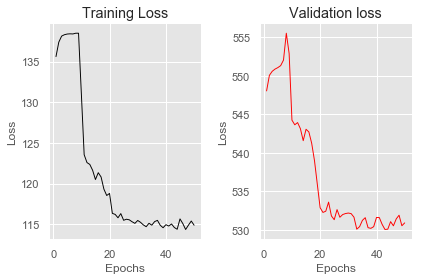

In [32]:
#Train and validation Loss
plt.style.use('ggplot')
f, (ax1, ax2) = plt.subplots(1, 2)

epochs = range(1,51)

ax1.plot(epochs, train_NLL,'black',label='Training loss', linewidth=0.95)
ax1.set_title('Training Loss')
ax1.set(xlabel='Epochs', ylabel='Loss')

ax2.plot(epochs, test_NLL, 'red', label='validation loss', linewidth=0.95)
ax2.set_title('Validation loss')
ax2.set(xlabel='Epochs', ylabel='Loss')

plt.tight_layout()

#Code below is for saving the image
#plt.savefig('images/train_valid_loss.png')

In [33]:
"""Converting predictions to python value"""
predicted = []
for i in range(len(prediction)):
    predicted.append(prediction[i].item())

In [37]:
from sklearn.metrics import mean_squared_error

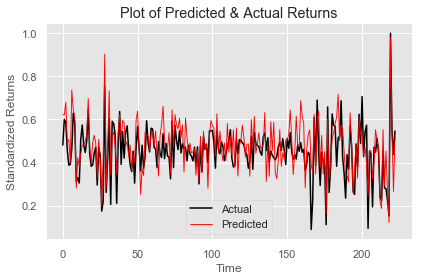

In [38]:
#Plot of SRNN Predictions
plt.style.use('ggplot')
plt.title('Plot of Predicted & Actual Returns')
plt.xlabel('Time')
plt.ylabel('Standardized Returns')
plt.plot(test_arr, 'black',label='Actual')
plt.plot(prediction, 'red', label='Predicted', linewidth=0.90)
plt.tight_layout()
plt.legend()

#Code below is for saving the image
#plt.savefig('images/SRNN_prediction.png')

In [39]:
#Comptuing MSE of SRNN's prediction and test set
mean_squared_error(prediction, test_arr)

0.007608477133720946

In [40]:
'''LSTM Model'''
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from ta import *
from pandas import DataFrame
from pandas import concat
import math
from numpy import reshape
from sklearn.preprocessing import MinMaxScaler
from numpy import array

In [42]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [43]:
#Reading Dataset
train = pd.read_csv("../4_Data/S&P500_train.csv") #Data from 1st Jan 2009 to 31 dec 2017
test = pd.read_csv("../4_Data/S&P500_test.csv") #Data from 1st Jan 2018 to 31 Dec 2018
train = add_all_ta_features(train, "Open Price", "High Price", "Low Price", "Close Price", "Volume", fillna=True)
test = add_all_ta_features(test, "Open Price", "High Price", "Low Price", "Close Price", "Volume", fillna=True)
train['returns'] = train['Close Price'].pct_change()
test['returns'] = test['Close Price'].pct_change()
train = train.dropna()
test = test.dropna()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ta/trend.py:170: RuntimeWarning: divide by zero encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ta/trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ta/trend.py:174: RuntimeWarning: divide by zero encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ta/trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ta/trend.py:176: RuntimeWarning: invalid value encountered in subtract
  dx = 100 * np.abs((dip - din) / (dip + din))


In [44]:
EPOCH = 20  # train the training data n times
BATCH_SIZE = 63
TIME_STEP = 28  # rnn time step / image height
INPUT_SIZE = 63  # rnn input size / image width
LR = 0.001  # learning rate

In [45]:
x_train = train.drop(['returns', 'Date'], axis=1)
y_train = train['returns']

x_test = test.drop(['returns', 'Date'], axis=1)
y_test = test['returns']

In [46]:
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

y_train = array(y_train)
y_train = y_train.reshape(y_train.shape[0], 1)
y_train = scaler.fit_transform(y_train)

y_test = array(y_test)
y_test = y_test.reshape(y_test.shape[0], 1)
y_test = scaler.fit_transform(y_test)

x_train = series_to_supervised(x_train, n_in=TIME_STEP-1, n_out=1)
x_train = x_train.values
x_train = x_train[:, :-63]

y_train  = series_to_supervised(y_train, n_in=TIME_STEP-1, n_out=2)
y_train = y_train.values
y_train = y_train[:, -1:]

x_test = series_to_supervised(x_test, n_in=TIME_STEP-1, n_out=1)
x_test = x_test.values
x_test = x_test[:, :-63]

y_test  = series_to_supervised(y_test, n_in=TIME_STEP-1, n_out=2)
y_test = y_test.values
y_test = y_test[:, -1:]

In [47]:
x_train = reshape(x_train, (x_train.shape[0], TIME_STEP-1, 63)) #n, lookback, predictors, N,T,P
y_train = reshape(y_train, (y_train.shape[0], 1, 1))
x_test = reshape(x_test, (x_test.shape[0], TIME_STEP-1, 63)) #n, lookback, predictors, N,T,P
y_test = reshape(y_test, (y_test.shape[0], 1, 1))

x_train = x_train[1:]
x_test = x_test[1:]

y_test = reshape(test_arr, (len(test_arr), 1 ,1))


x_train = Variable(torch.from_numpy(x_train))
x_test = Variable(torch.from_numpy(x_test))
y_train = Variable(torch.from_numpy(y_train))
y_test = Variable(torch.from_numpy(y_test))

In [49]:
train = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)

In [50]:
"""Shape of train and test set"""
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([2235, 27, 63]) torch.Size([2235, 1, 1])
torch.Size([223, 27, 63]) torch.Size([223, 1, 1])


In [51]:
    class RNN(nn.Module):
        def __init__(self):
            super(RNN, self).__init__()

            self.rnn = nn.LSTM(  # if use nn.RNN(), it hardly learns
                input_size=INPUT_SIZE,
                hidden_size=63,  # rnn hidden unit
                num_layers=6,  # number of rnn layer
                batch_first=True,  # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            )
            self.layer1 = nn.ReLU()
            self.layer2 = nn.Linear(in_features=63, out_features=32)
            self.layer3 = nn.ReLU()
            self.out = nn.Linear(63, 1)

        def forward(self, x):
            # x shape (batch, time_step, input_size)
            # r_out shape (batch, time_step, output_size)
            # h_n shape (n_layers, batch, hidden_size)
            # h_c shape (n_layers, batch, hidden_size)
            r_out, (h_n, h_c) = self.rnn(x, None)  # None represents zero initial hidden state

            # choose r_out at the last time step
            out = self.out(r_out[:, -1, :])
            return out    

In [52]:
    rnn = RNN()

    optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)  # optimize all rnn parameters
    loss_func = torch.nn.MSELoss(reduction='mean')

In [53]:
    from sklearn.metrics import mean_squared_error
    for epoch in range(EPOCH):
        for step, (b_x, b_y) in enumerate(train_loader):  # gives batch data
            b_y = reshape(b_y, (b_y.shape[0], 1))
            output = rnn(b_x.float())  # rnn output
            loss = loss_func(output, b_y.float())  # cross entropy loss
            optimizer.zero_grad()  # clear gradients for this training step
            loss.backward()  # backpropagation, compute gradients
            optimizer.step()  # apply gradients

        print('Epoch: {}/{}.............'.format(epoch, EPOCH), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 0/20............. Loss: 0.0015
Epoch: 1/20............. Loss: 0.0009
Epoch: 2/20............. Loss: 0.0009
Epoch: 3/20............. Loss: 0.0009
Epoch: 4/20............. Loss: 0.0008
Epoch: 5/20............. Loss: 0.0008
Epoch: 6/20............. Loss: 0.0008
Epoch: 7/20............. Loss: 0.0008
Epoch: 8/20............. Loss: 0.0008
Epoch: 9/20............. Loss: 0.0008
Epoch: 10/20............. Loss: 0.0008
Epoch: 11/20............. Loss: 0.0008
Epoch: 12/20............. Loss: 0.0008
Epoch: 13/20............. Loss: 0.0008
Epoch: 14/20............. Loss: 0.0008
Epoch: 15/20............. Loss: 0.0008
Epoch: 16/20............. Loss: 0.0008
Epoch: 17/20............. Loss: 0.0008
Epoch: 18/20............. Loss: 0.0008
Epoch: 19/20............. Loss: 0.0008


In [56]:
test_output = rnn(x_test.float())

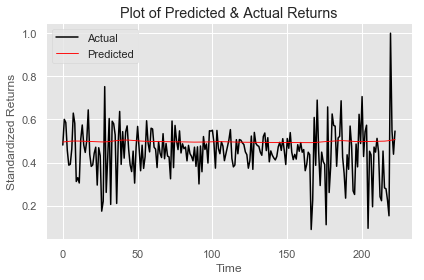

In [58]:
#LSTM Predictions
plt.title('Plot of Predicted & Actual Returns')
plt.xlabel('Time')
plt.ylabel('Standardized Returns')
plt.plot(test_arr, 'black',label='Actual')
plt.plot(test_output.detach(), 'red', label='Predicted', linewidth=0.9)
plt.tight_layout()
plt.legend()

#Code below is for saving the image
#plt.savefig('images/LSTM_prediction.png')

In [59]:
mse = mean_squared_error(test_output.detach(), test_arr)
mse

0.015169303380313259